TODO
________________

* Test with pre-prossed data -> DONE
* Make saving module features and saving CSV of models tested -> DONE
* Make Validation stuff -> DONE
* Fix GPU not being used in training? -> DONE Image Prosessing issue
* Clean up pre/prossing files -> DONE
* Clean up NN classes files -> DONE
* Clean up Reddit Scraper Files -> DONE
* Add L1/L2 Regulation / Dropouts -> DONE 
* Make Save function -> DONE
____________

* Do learn transfer to other libraries
* finally clean up RedditScraper, for real this time

In [9]:
# Torch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Other
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from glob import glob
from PIL import Image

# Import created modules
from modules.Neural_Work_Library import nn as nnlib
from modules.Preprocess_Validation import preprocess

Create Libraries/Convert set Transform to convert to Tensors

In [10]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_folder = nnlib.MemeOrCatDataSet(data_dir="../DataBaseV2/train/", transform=transform)
valid_folder = nnlib.MemeOrCatDataSet(data_dir="../DataBaseV2/valid/", transform=transform)

train_loader = DataLoader(train_folder, batch_size=124, shuffle=True, pin_memory=True, pin_memory_device="cuda:0")
valid_loader = DataLoader(valid_folder, batch_size=64, shuffle=False, pin_memory=True, pin_memory_device="cuda:0")

# Load Pre-prosser for test set
transform_full = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])
PreProssor = preprocess.PreProcess(transform_full)

Create NN instance, Set GPU (if available)

In [130]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(device))

# create model instance
model = nnlib.MemeClassConv2d()
model.to(device, non_blocking=True)
model.total_epochs = 0

train_losses, val_losses = [], []

# loss Function
criterion = nn.CrossEntropyLoss()

NVIDIA GeForce RTX 4070 Ti


Train Model with Epochs

In [131]:
num_epoch = 40

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the regularization strength for L1 and L2
l2_lambda = 0.001  # Adjust this value as needed

for epoch in tqdm(range(num_epoch), desc="Training Model"):

    # Train cycle
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Optimizer / Backwards prop
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # L2 regularization
        loss += l2_lambda * sum(torch.sum(param ** 2) for param in model.parameters())

        loss.backward()
        optimizer.step()

        # Calculate train loss
        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation cycle
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            # Calculate Val loss
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
    val_loss = running_loss / len(valid_loader.dataset)
    val_losses.append(val_loss)

    # print EPOCH
    print(f"Epoch {epoch+1}/{num_epoch} - Train Loss {train_loss}, valid_loss {val_loss}")
    model.total_epochs += 1


Training Model:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40 - Train Loss 0.5866473003240962, valid_loss 0.24500666558742523
Epoch 2/40 - Train Loss 0.3988959470388159, valid_loss 0.23780182003974915
Epoch 3/40 - Train Loss 0.33129756546568595, valid_loss 0.22254744917154312
Epoch 4/40 - Train Loss 0.28603534506343875, valid_loss 0.22171800583600998
Epoch 5/40 - Train Loss 0.2741840978152077, valid_loss 0.219781756401062
Epoch 6/40 - Train Loss 0.25810946793516354, valid_loss 0.2059050351381302
Epoch 7/40 - Train Loss 0.23562703976872823, valid_loss 0.21867433190345764
Epoch 8/40 - Train Loss 0.239565715427309, valid_loss 0.18742328137159348
Epoch 9/40 - Train Loss 0.23090819777802116, valid_loss 0.1587451472878456
Epoch 10/40 - Train Loss 0.21840495453483758, valid_loss 0.16216915100812912
Epoch 11/40 - Train Loss 0.20042667347186535, valid_loss 0.16348592936992645
Epoch 12/40 - Train Loss 0.19455407438420202, valid_loss 0.1643715351819992
Epoch 13/40 - Train Loss 0.1917480667868129, valid_loss 0.167291309684515
Epoch 14/40 - Train L

Visulize training/Validation Loss

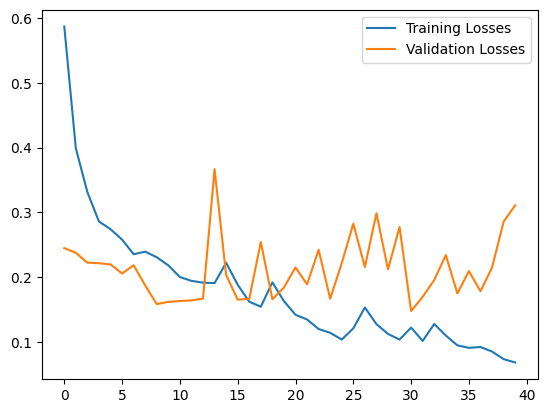

In [132]:
fig, ax = plt.subplots()

ax = sns.lineplot(train_losses, label='Training Losses')
ax = sns.lineplot(val_losses, label='Validation Losses')

plt.show()

Validate and Save current model

In [13]:
cats = glob('../DataBaseV2/test/cat/*')
memes = glob('../DataBaseV2/test/memes/*')
class_names = train_folder.classes
results = {}

for cat, meme in zip(cats, memes):
    cat_org, cat_tensor = PreProssor.process_image(cat)
    meme_org, meme_tensor = PreProssor.process_image(meme)

    results[cat] = [nnlib.predict(model, cat_tensor, device, class_names), 'cat']
    results[meme] = [nnlib.predict(model, meme_tensor, device, class_names), 'memes']

keys = [str(key).split('\\')[1] for key in results.keys()]
pred_values = [result[0] for result in results.values()]
real_values = [result[1] for result in results.values()]

results_df = pd.DataFrame({"ID":keys, "Predict":pred_values, "Real":real_values})

In [14]:
results_df[['Predict', 'Real']].value_counts()

Predict  Real 
cat      cat      76
memes    memes    75
cat      memes     7
memes    cat       6
Name: count, dtype: int64

In [15]:
results_df['Predict'].value_counts()

Predict
cat      83
memes    81
Name: count, dtype: int64

Kappa:0.84 |  Recall:0.92 |  F1:0.92 |  Precision:0.92


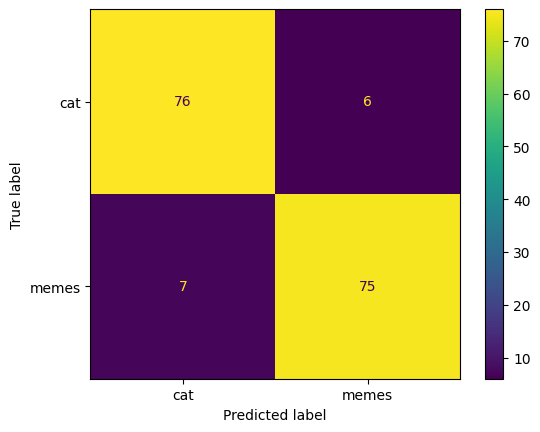

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score, recall_score, f1_score, precision_score

matrix = confusion_matrix(y_pred=results_df['Predict'], y_true=results_df['Real'])
kappa = cohen_kappa_score(y1=results_df['Predict'], y2=results_df['Real'])
recall = recall_score(y_true=results_df['Predict'], y_pred=results_df['Real'], pos_label='cat')
f1 = f1_score(y_pred=results_df['Predict'], y_true=results_df['Real'], pos_label='cat')
precision = precision_score(y_pred=results_df['Predict'], y_true=results_df['Real'], pos_label='cat')

print(f"Kappa:{kappa:.2f} |  Recall:{recall:.2f} |  F1:{f1:.2f} |  Precision:{precision:.2f}")

disp = ConfusionMatrixDisplay(matrix, display_labels=class_names)
disp.plot()
plt.show()

In [18]:
model_name = model._get_name()
parameters = [[[name, pram.size()] for name, pram in model.named_parameters()]]
total_epochs = model.total_epochs

output = pd.DataFrame({"Name":model_name, "kappa":kappa, "recall":recall, "f1":f1, "precision":precision, "epochs":total_epochs, "Parameters":parameters}, index=range(1, 2))
output

,Name,kappa,recall,f1,precision,epochs,Parameters
1,MemeClassConv2d,0.841463,0.915663,0.921212,0.915663,68,"[[conv1.weight, (6, 3, 5, 5)], [conv1.bias, (6..."


In [104]:
path = "../models/models.csv"
model_name = f"{model._get_name()}_V2"

save = False
if save is True:
    try:
        output_csv = pd.read_csv('../models/models.csv')
        output = pd.concat([output_csv, output])
        output.to_csv('../models/models.csv', index=False)
        torch.save(model, f"../models/{model_name}")

    except:
        output.to_csv('../models/models.csv', index=False)
